In [1]:
import torch
import torchvision

import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.transforms import Normalize
from torch.optim.lr_scheduler import ExponentialLR

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')

Using: cuda


In [2]:
class FastSRGAN(nn.Module):
    """SRGAN for fast super resolution."""

    def __init__(self,force_cpu=False):
        """
        Initializes the Mobile SRGAN class.
        Args:
            args: CLI arguments that dictate how to build the model.
        Returns:
            None
        """

        #args
        self.hr_size=384
        self.lr=0.0001
        super().__init__()

        if(not force_cpu):
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = 'cpu'
        
        self.hr_height = self.hr_size
        self.hr_width = self.hr_size
        self.lr_height = self.hr_height // 4  # Low resolution height
        self.lr_width = self.hr_width // 4  # Low resolution width
        self.lr_shape = (3, self.lr_height, self.lr_width)
        self.hr_shape = (3, self.hr_height, self.hr_width)
        self.iterations = 0

        # Number of inverted residual blocks in the mobilenet generator
        self.n_residual_blocks = 6

        self.vgg = self.build_vgg().to(device)
        self.vgg.eval()

        # Calculate output shape of D (PatchGAN)
        patch = int(self.hr_height / 2 ** 4)
        self.disc_patch = (1, patch, patch)

        # Number of filters in the first layer of G and D
        self.gf = 32  # Realtime Image Enhancement GAN Galteri et al.
        self.df = 32

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator().to(self.device)

        # Build and compile the generator for pretraining.
        self.generator = self.build_generator().to(self.device)


        # Loss definition
        self.GANcriterion = nn.BCEWithLogitsLoss()
        self.MSELoss = nn.MSELoss()

        # Optimizer and scheduler definition
        self.gen_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.lr)
        self.disc_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr * 5)

        self.gen_schedule = ExponentialLR(self.gen_optimizer, gamma=0.1, last_epoch=-1)
        self.disc_schedule = ExponentialLR(self.disc_optimizer, gamma=0.1, last_epoch=-1)

    def content_loss(self, hr, sr):
        sr = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])((sr + 1.0) * 255.0 / 2.0)
        hr = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])((hr + 1.0) * 255.0 / 2.0)
        sr_features = self.vgg(sr) / 12.75
        hr_features = self.vgg(hr) / 12.75
        return F.mse_loss(hr_features, sr_features)

    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        vgg = vgg19(pretrained=True).features
        for param in vgg.parameters():
            param.requires_grad = False

        model = nn.Sequential(*list(vgg.children())[:36])

        return model

    def build_generator(self):
        """Build the generator that will do the Super Resolution task.
        Based on the Mobilenet design. Idea from Galteri et al."""
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels, expansion=6, stride=1, alpha=1.0):
                super(ResidualBlock, self).__init__()
                self.expansion = expansion
                self.stride = stride
                self.in_channels = in_channels
                self.out_channels = int(out_channels * alpha)
                self.pointwise_conv_filters = self._make_divisible(self.out_channels, 8)
                self.conv1 = nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=True)
                self.bn1 = nn.BatchNorm2d(in_channels * expansion)
                self.conv2 = nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=True)
                self.bn2 = nn.BatchNorm2d(in_channels * expansion)
                self.conv3 = nn.Conv2d(in_channels * expansion, self.pointwise_conv_filters, kernel_size=1, stride=1, padding=0, bias=True)
                self.bn3 = nn.BatchNorm2d(self.pointwise_conv_filters)
                self.relu = nn.ReLU(inplace=True)
                self.skip_add = (stride == 1 and in_channels == self.pointwise_conv_filters)

            def forward(self, x):
                identity = x

                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)

                out = self.conv2(out)
                out = self.bn2(out)
                out = self.relu(out)

                out = self.conv3(out)
                out = self.bn3(out)

                if self.skip_add:
                    out = out + identity

                return out

            def _make_divisible(self, v, divisor, min_value=None):
                if min_value is None:
                    min_value = divisor
                new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
                if new_v < 0.9 * v:
                    new_v += divisor
                return new_v

        class Generator(nn.Module):
            def __init__(self, in_channels, num_residual_blocks, gf):
                super(Generator, self).__init__()
                self.num_residual_blocks = num_residual_blocks
                self.gf = gf

                self.conv1 = nn.Conv2d(in_channels, gf, kernel_size=3, stride=1, padding=1)
                self.bn1 = nn.BatchNorm2d(gf)
                self.prelu1 = nn.PReLU()

                self.residual_blocks = self.make_layer(ResidualBlock, gf, num_residual_blocks)

                self.conv2 = nn.Conv2d(gf, gf, kernel_size=3, stride=1, padding=1)
                self.bn2 = nn.BatchNorm2d(gf)

                self.upsample1 = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                    nn.Conv2d(gf, gf, kernel_size=3, stride=1, padding=1),
                    nn.PReLU()
                )

                self.upsample2 = nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                    nn.Conv2d(gf, gf, kernel_size=3, stride=1, padding=1),
                    nn.PReLU()
                )

                self.conv3 = nn.Conv2d(gf, 3, kernel_size=3, stride=1, padding=1)
                self.tanh = nn.Tanh()

            def make_layer(self, block, out_channels, blocks):
                layers = []
                for _ in range(blocks):
                    layers.append(block(out_channels, out_channels))
                return nn.Sequential(*layers)

            def forward(self, x):
                out1 = self.prelu1(self.bn1(self.conv1(x)))
                out = self.residual_blocks(out1)
                out = self.bn2(self.conv2(out))
                out = out + out1
                out = self.upsample1(out)
                out = self.upsample2(out)
                out = self.tanh(self.conv3(out))
                return out

        return Generator(self.lr_shape[0], self.n_residual_blocks, self.gf)

    def build_discriminator(self):
        """Builds a discriminator network based on the SRGAN design."""

        class Discriminator(nn.Module):
            def __init__(self, df):
                super(Discriminator, self).__init__()
                self.conv1 = nn.Conv2d(3, df, kernel_size=3, stride=1, padding=1)
                self.lrelu1 = nn.LeakyReLU(0.2)

                self.conv2 = nn.Conv2d(df, df, kernel_size=3, stride=2, padding=1)
                self.bn2 = nn.BatchNorm2d(df)
                self.lrelu2 = nn.LeakyReLU(0.2)

                self.conv3 = nn.Conv2d(df, df * 2, kernel_size=3, stride=1, padding=1)
                self.bn3 = nn.BatchNorm2d(df * 2)
                self.lrelu3 = nn.LeakyReLU(0.2)

                self.conv4 = nn.Conv2d(df * 2, df * 2, kernel_size=3, stride=2, padding=1)
                self.bn4 = nn.BatchNorm2d(df * 2)
                self.lrelu4 = nn.LeakyReLU(0.2)

                self.conv5 = nn.Conv2d(df * 2, df * 4, kernel_size=3, stride=1, padding=1)
                self.bn5 = nn.BatchNorm2d(df * 4)
                self.lrelu5 = nn.LeakyReLU(0.2)

                self.conv6 = nn.Conv2d(df * 4, df * 4, kernel_size=3, stride=2, padding=1)
                self.bn6 = nn.BatchNorm2d(df * 4)
                self.lrelu6 = nn.LeakyReLU(0.2)

                self.conv7 = nn.Conv2d(df * 4, df * 8, kernel_size=3, stride=1, padding=1)
                self.bn7 = nn.BatchNorm2d(df * 8)
                self.lrelu7 = nn.LeakyReLU(0.2)

                self.conv8 = nn.Conv2d(df * 8, df * 8, kernel_size=3, stride=2, padding=1)
                self.bn8 = nn.BatchNorm2d(df * 8)
                self.lrelu8 = nn.LeakyReLU(0.2)

                self.conv9 = nn.Conv2d(df * 8, 1, kernel_size=3, stride=1, padding=1)
                self.sigmoid = nn.Sigmoid()

            def forward(self, x):
                out = self.lrelu1(self.conv1(x))
                out = self.lrelu2(self.bn2(self.conv2(out)))
                out = self.lrelu3(self.bn3(self.conv3(out)))
                out = self.lrelu4(self.bn4(self.conv4(out)))
                out = self.lrelu5(self.bn5(self.conv5(out)))
                out = self.lrelu6(self.bn6(self.conv6(out)))
                out = self.lrelu7(self.bn7(self.conv7(out)))
                out = self.lrelu8(self.bn8(self.conv8(out)))
                out = self.sigmoid(self.conv9(out))
                return out

        return Discriminator(self.df)


    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self,data):
        self.x = data[0].to(self.device)
        self.y = data[1].to(self.device)

    def forward(self):
        self.sr = self.generator(self.x)

    def backward_D(self):

        real = torch.ones((x.size(0),) + model.disc_patch).to(device)
        fake = torch.zeros((x.size(0),) + model.disc_patch).to(device)
        
        fake_preds = self.discriminator(self.sr.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds,fake)
        real_preds = self.discriminator(self.y)
        self.loss_D_real = self.GANcriterion(real_preds,real)
        self.loss_D = (self.loss_D_fake + self.loss_D_real)
        self.loss_D.backward()

    def backward_G(self):
        valid = torch.ones((x.size(0),) + model.disc_patch).to(device)

        fake_preds = self.discriminator(self.sr)
        self.loss_G_Content = self.content_loss(self.y, self.sr)
        self.loss_G_GAN = 1e-3 * self.GANcriterion(fake_preds, valid)
        self.loss_G_MSE = self.MSELoss(self.sr, self.y)
        self.loss_G = self.loss_G_Content + self.loss_G_GAN + self.loss_G_MSE

        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.discriminator.train()
        self.set_requires_grad(self.discriminator, True)
        self.disc_optimizer.zero_grad()
        self.backward_D()
        self.disc_optimizer.step()

        self.generator.train()
        self.set_requires_grad(self.discriminator, False)
        self.gen_optimizer.zero_grad()
        self.backward_G()
        self.gen_optimizer.step()




In [22]:
def build_generator():
    
    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, expansion=6, stride=1, alpha=1.0):
            super(ResidualBlock, self).__init__()
            self.expansion = expansion
            self.stride = stride
            self.in_channels = in_channels
            self.out_channels = int(out_channels * alpha)
            self.pointwise_conv_filters = self._make_divisible(self.out_channels, 8)
            self.conv1 = nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=True)
            self.bn1 = nn.BatchNorm2d(in_channels * expansion)
            self.conv2 = nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=True)
            self.bn2 = nn.BatchNorm2d(in_channels * expansion)
            self.conv3 = nn.Conv2d(in_channels * expansion, self.pointwise_conv_filters, kernel_size=1, stride=1, padding=0, bias=True)
            self.bn3 = nn.BatchNorm2d(self.pointwise_conv_filters)
            self.relu = nn.ReLU(inplace=True)
            self.skip_add = (stride == 1 and in_channels == self.pointwise_conv_filters)

        def forward(self, x):
            identity = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)
            out = self.relu(out)

            out = self.conv3(out)
            out = self.bn3(out)

            if self.skip_add:
                out = out + identity

            return out

        @staticmethod
        def _make_divisible(v, divisor, min_value=None):
            if min_value is None:
                min_value = divisor
            new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
            if new_v < 0.9 * v:
                new_v += divisor
            return new_v

    class Generator(nn.Module):
        def __init__(self, in_channels, num_residual_blocks, gf):
            super(Generator, self).__init__()
            self.num_residual_blocks = num_residual_blocks
            self.gf = gf

            self.conv1 = nn.Conv2d(in_channels, gf, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(gf)
            self.prelu1 = nn.PReLU()

            self.residual_blocks = self.make_layer(ResidualBlock, gf, num_residual_blocks)

            self.conv2 = nn.Conv2d(gf, gf, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(gf)

            self.upsample1 = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(gf, gf, kernel_size=3, stride=1, padding=1),
                nn.PReLU()
            )

            self.upsample2 = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(gf, gf, kernel_size=3, stride=1, padding=1),
                nn.PReLU()
            )

            self.conv3 = nn.Conv2d(gf, 3, kernel_size=3, stride=1, padding=1)
            self.tanh = nn.Tanh()

        def make_layer(self, block, out_channels, blocks):
            layers = []
            for _ in range(blocks):
                layers.append(block(out_channels, out_channels))
            return nn.Sequential(*layers)

        def forward(self, x):
            out1 = self.prelu1(self.bn1(self.conv1(x)))
            out = self.residual_blocks(out1)
            out = self.bn2(self.conv2(out))
            out = out + out1
            out = self.upsample1(out)
            out = self.upsample2(out)
            out = self.tanh(self.conv3(out))
            return out

    return Generator(3, 6, 32)


In [23]:

def numpify(imgs):
    """
    Takes a batch of images
    """

    rgb_imgs = []
    for img in imgs:
        img_rgb = img.permute(1,2,0).to('cpu') ### MIGHT CRASH HERE
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [27]:
model=build_generator().to('cuda')
model.load_state_dict(torch.load('./generator_weight.pt'))

<All keys matched successfully>

In [28]:
image = Image.open('./comp2/Upscaled Image 914x609.png').convert('RGB')
image = image.resize((480, 320))
transform = transforms.Compose([
            transforms.ToTensor()
        ])
high_res = transform(image)
high_res=high_res.unsqueeze(dim=0).to('cuda')
data=(high_res,torch.tensor([1]))
model.eval()
with torch.no_grad():
    sr=model(high_res)
    #model.forward()
fake_imgs = numpify(sr)

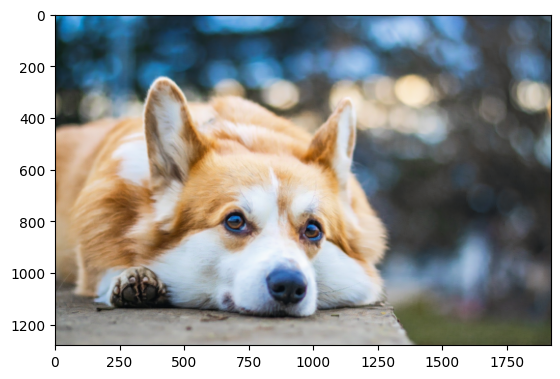

In [29]:
plt.imshow((fake_imgs[0]+1)/2)

In [7]:
sr_img = Image.fromarray((((fake_imgs[0]+1)/2) * 255).astype(np.uint8))
width = 1920
original_width, original_height = sr_img.size
height = int((width / original_width) * original_height)

# Resize the image to 1920 pixels width while maintaining the aspect ratio
sr_img_resized = sr_img.resize((width, height), Image.LANCZOS)

# Save the resized image
sr_img_resized.save('super_resolved_image_6.png')